## Prerequisites:
 - Reasonably up-to-date pytorch
 - Jupyter to run the notebook (or just follow along in a terminal)

Additional packages for onnx export and some other functions:

If running from Google Colab, skip this initial setup and set `using_colab = True` below it. It's better to set this up in your environment outside of Jupyter if you can, so that you don't have to restart the kernel and everything will just be installed, but it's here so that everything is in a single file.

In [ ]:
pip install opencv-python pycocotools matplotlib onnxruntime onnx

For original Segment Anything model:

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

And for MobileSAM:

In [ ]:
pip install git+https://github.com/ChaoningZhang/MobileSAM.git

Restart the kernel if needed and continue from here. This is mostly pulled from an example notebook in the above repository.
The quantized export example fails in the exact same way for each, so I will show only the non-quantized.
https://github.com/ChaoningZhang/MobileSAM/blob/master/notebooks/onnx_model_example.ipynb

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/1fOhTLdPHPzqk8Smn2O4YYXMu_nrIqGMZ?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

### **SKIP TO HERE IF RUNNING ON COLAB**

In [1]:
using_colab = True

In [7]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !{sys.executable} -m pip install 'git+https://github.com/ChaoningZhang/MobileSAM.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/refs/heads/master/weights/mobile_sam.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gjf3pi5_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gjf3pi5_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-5rfeohyj
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-5rfeohyj
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit 34bbbfdface3c18e5221aa7de6032d7220c6c6a1
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2025-04-29 17:57:58--  https://raw.githubusercontent.com/facebookresearch/segment-anything/m


## Set-up

In [5]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry, SamPredictor
from mobile_sam.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.11/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m

In [6]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))



### Base segment-anything checkpoint:

In [33]:

checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
onnx_model_path = "sam_onnx_test.onnx"
onnx_model_quantized_path = "sam_onnx_quantized_test.onnx"

### MobileSAM checkpoint:

In [38]:
checkpoint = "mobile_sam.pt"
model_type = "vit_t"
onnx_model_path = "mobilesam_onnx_test.onnx"
onnx_model_quantized_path = "mobilesam_onnx_quantized_test.onnx"

Run only **ONE** of the above, then continue from here

In [39]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)

In [40]:
import warnings



onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=16,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

Run the next cell to export a quantized model for testing as well.

In [41]:

quantize_dynamic(
    model_input=onnx_model_path,
    model_output=onnx_model_quantized_path,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)
onnx_model_path = onnx_model_quantized_path

## Example Image

In [11]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

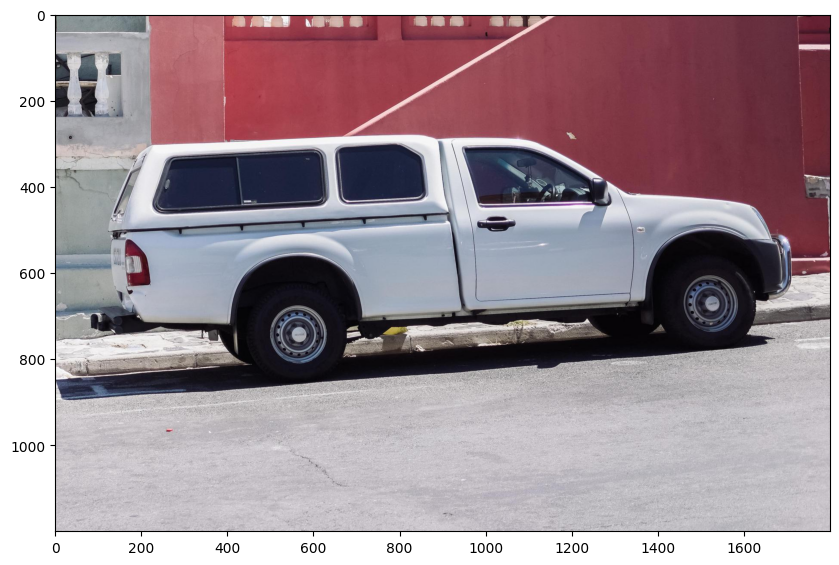

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Demonstrating that the ONNX export works normally:

In [19]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
sam.to(device='cpu')
predictor = SamPredictor(sam)

predictor.set_image(image)

image_embedding = predictor.get_image_embedding().cpu().numpy()

image_embedding.shape

(1, 256, 64, 64)

In [20]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

masks.shape

(1, 1, 1200, 1800)

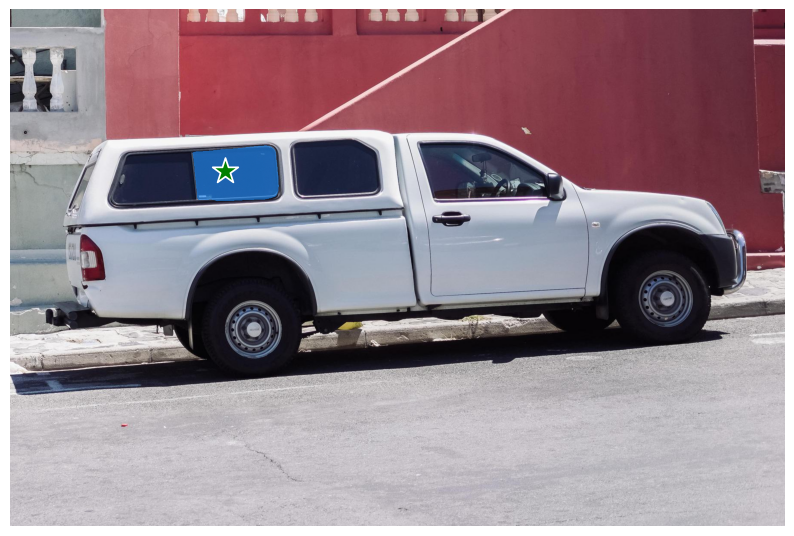

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### From here, use the ST AI developer cloud to replicate my path

Upload the model(s) you exported to the developer cloud


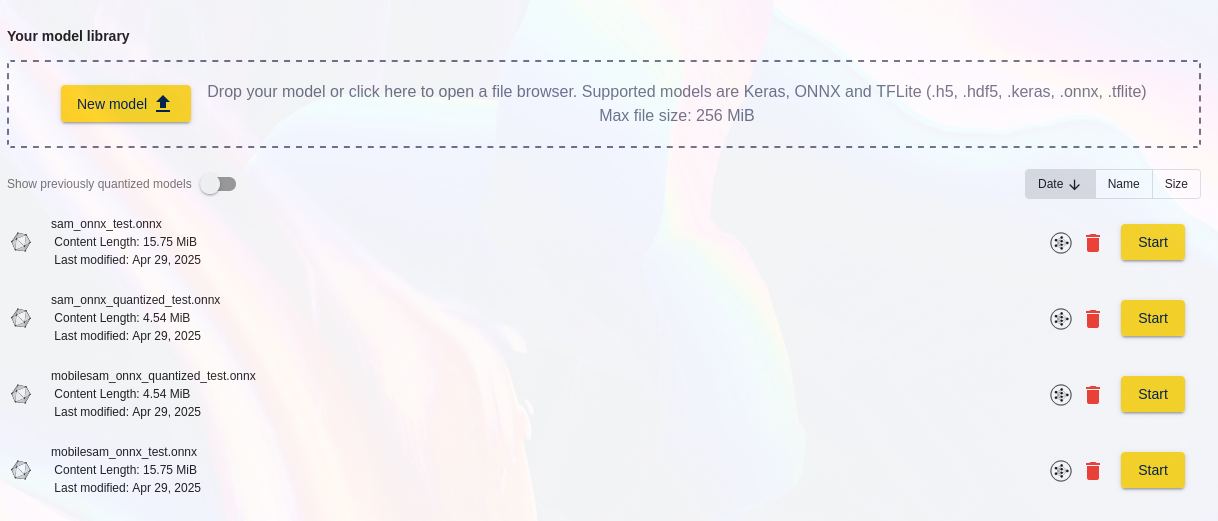

### Reproduction steps (online):
1. Click "Start" for one of the uploaded models
2. Select either the "STM32 MCUs" or "STM32 MCU with Neural-ART" option.

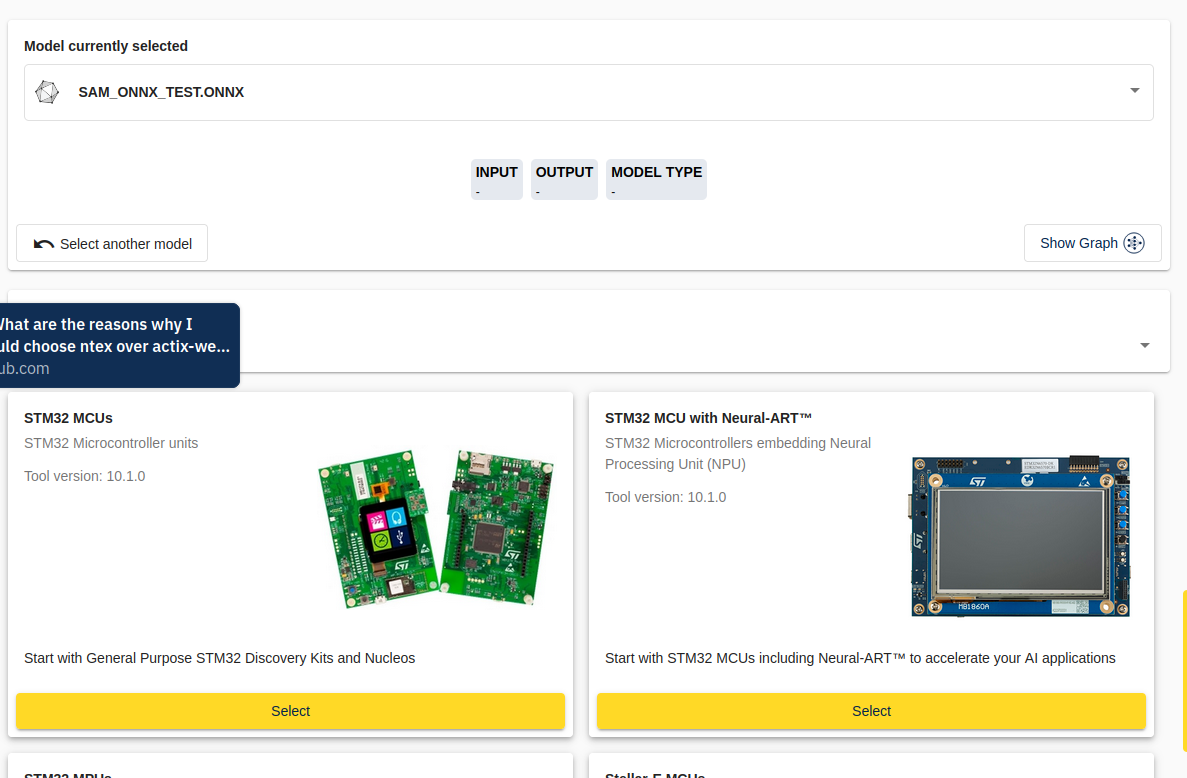

Alternatively, if you have the command line tools installed locally, here is the command it runs to attempt to optimize the model. I have tested with various options and the optimization fails with the same missing layers during any given session.
```
stedgeai analyze --model sam_onnx_test.onnx --optimization balanced --target stm32f4 --name network --workspace workspace --output output
```

3. Quantization fails with the following error:


```
Executing with:  {'model': '/tmp/quantization-service/364be47a-32cf-4fbe-9fee-aadd0183fa8a/sam_onnx_test.onnx', 'data': None, 'disable_per_channel': False}
Preprocess the model to infer shapes of each tensor
Quantizing model...
[ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running Resize node. Name:'/Resize_1' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/upsamplebase.h:289 void onnxruntime::UpsampleBase::ScalesValidation(const std::vector<float>&, onnxruntime::UpsampleMode) const scale > 0 was false. Scale value should be greater than 0.


2025-04-29 18:47:25.065034: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 18:47:25.092626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 18:47:27.265503470 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running Resize node. Name:'/Resize_1' Status Message: /onnxruntime_src/onnxruntime/core/providers/cpu/tensor/upsamplebase.h:289 void onnxruntime::UpsampleBase::ScalesValidation(const std::vector<float>&, onnxruntime::UpsampleMode) const scale > 0 was false. Scale value should be greater than 0.
```



4. If you proceed to the Optimize step and attempt to optimize the model, regardless of chosen options, it fails with missing layers.

The error shown in the terminal output for base Segment Anything is as follows as of April 29th:

```
>>> stedgeai analyze --model sam_onnx_test.onnx --optimization balanced --target stm32f4 --name network --workspace workspace --output output
ST Edge AI Core v2.1.0-20182 a437ed3c9
NOT IMPLEMENTED: Unsupported layer types: Range, OneHot

WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1745952619.982128   49783 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745952619.986266   49783 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

```



And the error for MobileSAM is essentially the same:

```
>>> stedgeai analyze --model mobilesam_onnx_test.onnx --st-neural-art custom@/tmp/stm32ai_service/bd956142-0ebc-44f3-a229-4b80725a433b/profile-f86c24b2-abce-402a-b057-8007c4ab4fa6.json --target stm32n6 --optimize.export_hybrid True --name network --workspace workspace --output output
ST Edge AI Core v2.1.0-20182 a437ed3c9
WARNING: Unsupported keys in the current profile custom are ignored: memory_desc
	> memory_desc is not a valid key anymore, use machine_desc instead
NOT IMPLEMENTED: Unsupported layer types: OneHot, Range

WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1745952743.621156   49941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745952743.625188   49941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

```



Quantized models show more missing layers:
```
>>> stedgeai analyze --model sam_onnx_quantized_test.onnx --optimization balanced --target stm32f4 --name network --workspace workspace --output output
ST Edge AI Core v2.1.0-20182 a437ed3c9
NOT IMPLEMENTED: Unsupported layer types: Range, MatMulInteger, OneHot, ConvInteger, DynamicQuantizeLinear

WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1745953514.277178   49979 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745953514.281585   49979 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
```


## Conclusion:

ST Edge AI is missing support for the OneHot, Range, MatMulInteger, ConvInteger, and DynamicQuantizeLinear layers. Documentation for the experienced quantization error also feels needed, as it is unclear how to resolve the problem detailed.
